# Script to predict dynamic time stepping of an ocean model

Written by Rachel Furner, April 2019.

Collaborative work with colleagues at BAS, and the ATI



1. Read in the data
2. Define input data and output data.
3. Split into test and train data.
4. Train the network
5. Run predictions on test data and assess.

In [2]:
print('test')

test


In [3]:
import xarray as xr
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import random

import os

import tensorflow as tf

#print(tf.__version__)

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import MaxPooling3D, Conv3D, UpSampling3D, Cropping3D

import gpflow
from gpflow.kernels import RBF, Periodic, ArcCosine

import pickle

print('imports done')

imports done


Define variables for this experiment

In [4]:
StepSize = 10 #number of timesteps forward which we want to predict
SkipOver = 10

Read in data files as Xarrays

In [5]:
DIR = '/data/oceans_output/open/racfur'
exp_list = ['4500yr_Windx0.50']
file_names = ['state.0000000000.t001.nc', 'state.0000340920.t001.nc', 'state.0000681840.t001.nc', 
              'state.0001022760.t001.nc', 'state.0001363680.t001.nc', 'state.0001704600.t001.nc',
              'state.0000170460.t001.nc', 'state.0000511380.t001.nc', 'state.0000852300.t001.nc', 
              'state.0001193220.t001.nc', 'state.0001534140.t001.nc', 'state.0001875060.t001.nc',
              'state.0002045520.t001.nc', 'state.0002215980.t001.nc', 'state.0002386440.t001.nc',
              'state.0002556900.t001.nc', 'state.0002727360.t001.nc', 'state.0002897820.t001.nc',
              'state.0003068280.t001.nc', 'state.0003238740.t001.nc']
file_list =[]
for exp in exp_list:
    print(exp)
    for file in file_names:
        print(file)
        file_list.append(os.path.join(DIR,exp,file))
print(file_list)

4500yr_Windx0.50
state.0000000000.t001.nc
state.0000340920.t001.nc
state.0000681840.t001.nc
state.0001022760.t001.nc
state.0001363680.t001.nc
state.0001704600.t001.nc
state.0000170460.t001.nc
state.0000511380.t001.nc
state.0000852300.t001.nc
state.0001193220.t001.nc
state.0001534140.t001.nc
state.0001875060.t001.nc
state.0002045520.t001.nc
state.0002215980.t001.nc
state.0002386440.t001.nc
state.0002556900.t001.nc
state.0002727360.t001.nc
state.0002897820.t001.nc
state.0003068280.t001.nc
state.0003238740.t001.nc
['/data/oceans_output/open/racfur/4500yr_Windx0.50/state.0000000000.t001.nc', '/data/oceans_output/open/racfur/4500yr_Windx0.50/state.0000340920.t001.nc', '/data/oceans_output/open/racfur/4500yr_Windx0.50/state.0000681840.t001.nc', '/data/oceans_output/open/racfur/4500yr_Windx0.50/state.0001022760.t001.nc', '/data/oceans_output/open/racfur/4500yr_Windx0.50/state.0001363680.t001.nc', '/data/oceans_output/open/racfur/4500yr_Windx0.50/state.0001704600.t001.nc', '/data/oceans_output

###### Define Input output pairs
Eventual aim is that inputs are full model field at t-stepsize and t, outputs are full model fields at t+StepSize.
For now, input is just Temp at just at time step t, and output is Temp at t+stepsize.

In future could involve lots of input variables.

StepSize can be changed easily (defined further up) - plan to test different values and see how well things work.

We take input,output pairs with 't' spaced by 'SkipOver' steps apart. Currently this is set as 1, but ideally would be larger, in bid to ensure some independance between samples. Balance between low values giving us lots of training samples, but also a desire for independant training samples

Need to amend below to loop through multiple files, so more training data, including data from different runs can be included.


In [6]:
training_data=[]
for file in file_list:
    ds   = xr.open_dataset(file)
    for time in range(StepSize, len(ds.T.data)-StepSize, SkipOver):
        training_data.append([ds.Temp.isel(T=time-StepSize), ds.Temp.isel(T=time), ds.Temp.isel(T=time+StepSize)])
        #training_data.append([ds.Temp.isel(T=time-StepSize), ds.Temp.isel(T=time),
        #                      ds.S.isel   (T=time-StepSize), ds.S.isel(T=time)   ,
        #                      ds.U.isel   (T=time-StepSize), ds.U.isel(T=time)   ,
        #                      ds.V.isel   (T=time-StepSize), ds.V.isel(T=time)   ,
        #                      ds.Temp.isel(T=time+StepSize),
        #    ])
    
#shuffle dataset
random.shuffle(training_data)
print(training_data[0][0].shape)

(42, 78, 11)


Plot two fields, 100 time steps apart

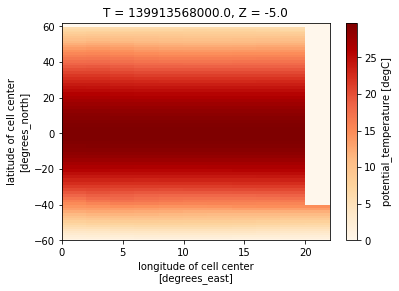

In [6]:
ds.Temp
fig, ax = plt.subplots(ncols=1)
ds.Temp.isel(T=0,Z=0).plot(cmap='OrRd')
fig.savefig('start.png')


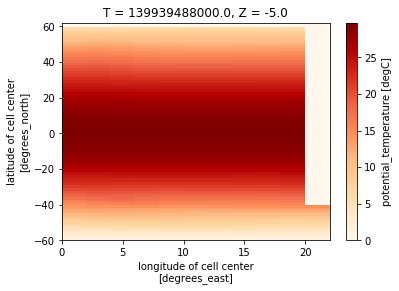

In [7]:
fig, ax = plt.subplots(ncols=1)
ds.Temp.isel(T=StepSize,Z=0).plot(cmap='OrRd')
fig.savefig('end.png')


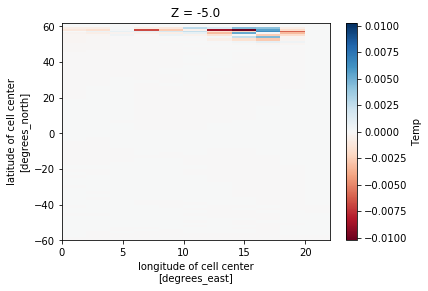

In [8]:
fig, ax = plt.subplots(ncols=1)
(ds.Temp.isel(T=StepSize,Z=0)-ds.Temp.isel(T=0,Z=0)).plot(cmap='RdBu' )
fig.savefig('diff.png')

Put this into X and Y arrays, ready for model to read

If using multiple input variables pad with NaN's so the arrays are all the same size (not done above, as it changes them to arrays, and easier to leave as lists) - not needed when just looking at temp

In [7]:
X=[]
Y=[]

#for feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label in training_data:
#        X.append([
#            np.pad(feat1.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat2.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat3.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat4.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat5.data, ((0,0),(0,1),(0,0)),'constant', constant_values=('NaN')),
#            np.pad(feat6.data, ((0,0),(0,1),(0,0)),'constant', constant_values=('NaN')),
#            np.pad(feat7.data, ((0,0),(0,0),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat8.data, ((0,0),(0,0),(0,1)),'constant', constant_values=('NaN')),
#             ])
#        Y.append(np.pad(label.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')))

for feat1,feat2,label in training_data:
        X.append([feat1.data, feat2.data])
        #X.append(feat1.data)
        Y.append(label.data)

# convert to arrays, as model wont accept a list
X=np.array(X).transpose(0, 2, 3, 4, 1)
X=np.array(X)
Y=np.array(Y)

print(X.shape)
print(Y.shape)

(5378, 42, 78, 11, 2)
(5378, 42, 78, 11)


Normalise data

In [8]:
def normalise_data(X):
    X=tf.keras/utils.normalize(X, axis=1)
    return X

print(X.shape)
print(X.shape[1:])

(5378, 42, 78, 11, 2)
(42, 78, 11, 2)


Trying a GP regressor for a single data point

In [9]:
coordx = 1
coordy = 1
coordz = 1

inputs = []
outputs = []
for time in range(StepSize, len(ds.T.data)-StepSize, SkipOver):
    Xnew = ds.Temp.isel(T=time)
    inputs.append([Xnew[coordx,coordy,coordz]])
          #Xnew[coordx,coordy+1,coordz],   Xnew[coordx,coordy-1,coordz],
          #Xnew[coordx+1,coordy,coordz],   Xnew[coordx-1,coordy,coordz],
          #Xnew[coordx+1,coordy+1,coordz], Xnew[coordx-1,coordy-1,coordz],
          #Xnew[coordx+1,coordy-1,coordz], Xnew[coordx-1,coordy+1,coordz]])
    outputs.append([ds.Temp.isel(T=time+StepSize)[coordx,coordy,coordz]])


inputs=np.array(inputs)
outputs=np.array(outputs)


k = gpflow.kernels.Matern52(1, lengthscales=0.3)
model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )

#
### Optimise
print('training')
gpflow.train.ScipyOptimizer().minimize(model, disp=True)


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


training
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.015436
  Number of iterations: 5
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.015436
  Number of iterations: 5
  Number of functions evaluations: 6


Try a single Layer NN, with the identity (i.e. linear) as the activation function to test basic set up (persistance forecast)

In [13]:
model = Sequential()
model.add(Activation('linear'))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X[:,:,:,:,1], Y, batch_size=32, epochs=3, validation_split=0.15)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 4571 samples, validate on 807 samples
Epoch 1/3
4571/4571 [==============================] - 3s 626us/sample - loss: 2.1647e-05 - acc: 0.9928 - val_loss: 2.3049e-05 - val_acc: 0.9927
Epoch 2/3
4571/4571 [==============================] - 3s 613us/sample - loss: 2.1647e-05 - acc: 0.9928 - val_loss: 2.3049e-05 - val_acc: 0.9927
Epoch 3/3
4571/4571 [==============================] - 3s 621us/sample - loss: 2.1647e-05 - acc: 0.9928 - val_loss: 2.3049e-05 - val_acc: 0.9927


In [10]:
model = Sequential()

#'flatten' inputs
model.add(Flatten())
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 4302 samples, validate on 1076 samples
Epoch 1/3


InvalidArgumentError: Input to reshape is a tensor with 2306304 values, but the requested shape has 1153152
	 [[{{node Reshape_11}}]]

In [15]:
model = Sequential()

#'flatten' inputs
model.add(Flatten())  
# define first hidden layer
model.add(Dense(36036))
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.2)



Train on 4302 samples, validate on 1076 samples
Epoch 1/3
4302/4302 [==============================] - 3471s 807ms/sample - loss: 6194.2614 - acc: 0.1339 - val_loss: 0.5496 - val_acc: 0.2020
Epoch 2/3
4302/4302 [==============================] - 3504s 814ms/sample - loss: 0.1769 - acc: 0.3101 - val_loss: 0.0496 - val_acc: 0.3340
Epoch 3/3
4302/4302 [==============================] - 3499s 813ms/sample - loss: 0.0237 - acc: 0.3918 - val_loss: 0.0080 - val_acc: 0.4479


In [8]:
model = Sequential()

#'flatten' inputs
model.add(Flatten())  
# define first hidden layer
model.add(Dense(36036))
model.add(Activation('relu'))
#reshape
model.add(Reshape(Y.shape[1:]))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 4302 samples, validate on 1076 samples
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/3
4302/4302 [==============================] - 2580s 600ms/sample - loss: 386.9854 - acc: 0.2287 - val_loss: 89.2470 - val_acc: 0.2304
Epoch 2/3
4302/4302 [==============================] - 2564s 596ms/sample - loss: 89.2533 - acc: 0.2304 - val_loss: 89.2470 - val_acc: 0.2304
Epoch 3/3
4302/4302 [==============================] - 2563s 596ms/sample - loss: 89.2533 - acc: 0.2304 - val_loss: 89.2470 - val_acc: 0.2304


##### NN attempt 1

trying using just conv layers - no pooling, so not an autoencoder type set up.

This runs, but results are diabolical....

Number of inputs = 42 * 78 * 11 * 2 = 72072 inputs. This is huge...

In [ ]:
model = Sequential()

model.add(Conv3D(72072, (3, 3, 3), input_shape=X.shape[1:], padding='same'))  #no shape change with padding...
model.add(Activation('relu'))
#model.add(Conv3D(72072, (5, 5, 5), input_shape=X.shape[1:], padding='same'))
#model.add(Activation('relu'))
#model.add(Conv3D(72072, (3, 3, 3), input_shape=X.shape[1:], padding='same'))
#model.add(Activation('linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.2)

##### NN Attemmpt 3:

Also tried with Dense layers instead...


In [ ]:
model = Sequential()

#'flatten' inputs
model.add(Flatten())   # should be dim 960
# define first hidden layer
model.add(Dense(72072))
model.add(Activation('relu'))
#add second hidden layer 
model.add(Dense(72072))
model.add(Activation('relu'))
#add third layer - output payer
model.add(Dense(36036))
#ouput layer should have linear activation function suitable for a regression problem
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=128, epochs=3, validation_split=0.2)

##### NN Attempt 4

A combination of Conv and dense layers...

In [ ]:
model = Sequential()

model.add(Conv3D(72072, (3, 3,3), input_shape=X.shape[1:], padding='same'))
model.add(Activation('relu'))

model.add(Conv3D(72072, (5, 5, 5), padding='same'))
model.add(Activation('relu'))

model.add(Conv3D(72072, (7, 7, 7), padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(72072))
#last layer should have linear activation function suitable for a regression problem
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=128, epochs=3, validation_split=0.2)